# Coherence Analyses

The notebook makes a comparison of the eigenvalue decay of coherence matrix in the case of the existence of microsiesmic events vs when there is no coherent event.

Coherence here is defined by Welch method for two signals, x and y as
$$Coherence(x,y) = \frac{E[P_{xy}]^2}{E[P_{xx}]E[P_{yy}]}$$

### Make imports and write functions

In [1]:
import scipy.signal as ss
import h5py
from IPython.display import HTML, display
import numpy as np
from matplotlib.animation import FuncAnimation
import matplotlib.pyplot as plt
from scipy.fft import ifft
from sklearn.utils.extmath import randomized_svd

In [2]:
def loadBradyHShdf5(file,normalize='yes'):
    '''

    Parameters
    ----------
    file : str
        path to brady hotspring h5py data file
    normalize : str, optional
        "yes" or "no". Indicates whether or not to remove laser drift and 
        normalize. The default is 'yes'.

    Returns
    -------
    data : np array
        channel by samples numpy array of data
    timestamp_arr : numpy array
        array of the timestamps corresponding to the various samples in the 
        data. Timestamps for brady hotspring data are with respect to the 
        beginning time of the survey.

    '''
    
    with h5py.File(file,'r') as open_file: 
        dataset = open_file['das']
        time=open_file['t']
        data=np.array(dataset)
        timestamp_arr=np.array(time)
    data = np.transpose(data)
    if normalize=='yes':
        nSamples=np.shape(data)[1]
        # get rid of laser drift
        med = np.median(data,axis=0)
        for i in range(nSamples):
          data[:,i] = data[:,i] - med[i]
          
        max_of_rows = abs(data[:,:]).sum(axis=1)
        data = data/ max_of_rows[:, np.newaxis]
    return data, timestamp_arr


def windowed_spectra(data: np.array, subwindow_len: int,overlap,freq=None,sample_interval=1):
    """
    Calculate the frequency domain representation of data in windows.
    """

    win_start = 0
    window_samples = int(subwindow_len / sample_interval)
    total_samples = data.shape[-1]
    overlap = int(overlap/sample_interval)
    intervals = np.arange(window_samples, total_samples+1, window_samples, dtype=int) # break time series into windowed intervals

    win_end = intervals[0]

    absolute_spectra = np.fft.rfft(data[:,win_start:win_end])
    win_spectra = absolute_spectra[np.newaxis]

    while win_end < total_samples:
        win_start = win_end - overlap
        win_end = win_start + window_samples
        absolute_spectra = np.fft.rfft(data[:,win_start:win_end])
        win_spectra = np.append(
            win_spectra, absolute_spectra[np.newaxis], axis=0
        )
        # win_start = win_end
        
    
    frequencies = np.fft.rfftfreq(window_samples, sample_interval)

    return win_spectra, frequencies

def welch_coherence(data: np.array, subwindow_len: int,overlap,freq=None,sample_interval=1):
    """
    Calculate the coherence matrix at all (or particular frequencies: yet to be implemented)
    using the welch method.
    """

    win_spectra, frequencies = windowed_spectra(data, subwindow_len,overlap,freq,sample_interval)

    normalizer = np.sum(np.absolute(win_spectra)**2, axis=0)
    normalizer = np.tile(normalizer,(normalizer.shape[0],1,1))
    normalizer = normalizer * normalizer.transpose((1,0,2))
    normalizer = normalizer.transpose(2,1,0)

    welch_numerator = np.matmul(win_spectra.transpose(2,1,0), np.conjugate(win_spectra.transpose(2,0,1)))
    welch_numerator = np.absolute(welch_numerator)**2
    coherence = np.multiply(welch_numerator,1/normalizer)

    return coherence, frequencies

def normalised_windowed_spectra(data: np.array, subwindow_len: int,overlap,freq=None,sample_interval=1):

    win_spectra, frequencies = windowed_spectra(data, subwindow_len,overlap,freq,sample_interval)

    normalizer = np.sum(np.absolute(win_spectra)**2, axis=0)
    normalizer = np.tile(normalizer,(win_spectra.shape[0],1,1))
    normalizer = normalizer.transpose(2,1,0)

    normalized_spectra = win_spectra.transpose(2,1,0) / normalizer

    return normalized_spectra, frequencies


### Parameters for data and tests

In [3]:
samples_per_sec=1000
fsize=15
start_ch = 1000
nchannels = 3000
# start_ch = 3100
# nchannels = 5100

In [4]:
subwin_width = 4096 # number of samples in each subwindow
num_subwins = 10 # number of subwindows to average over
avgwin_width = num_subwins * subwin_width # number of samples in averaging window

# Background noise test

In [7]:
file = r"D:\CSM\Mines_Research\Test_data\Brady Hotspring\PoroTomo_iDAS16043_160312000018.h5"
data_noise,_= loadBradyHShdf5(file,normalize='no')

file = r"D:\CSM\Mines_Research\Test_data\Brady Hotspring\PoroTomo_iDAS16043_160312000048.h5"
data_noise2,_= loadBradyHShdf5(file,normalize='no')

data_noise = np.append(data_noise,data_noise2,axis=1)

In [67]:
norm_win_spectra, frequencies = normalised_windowed_spectra(data_noise[start_ch:nchannels+start_ch:int(nchannels/200)], 5, 2.5, sample_interval=0.001)

(2501, 200, 23)

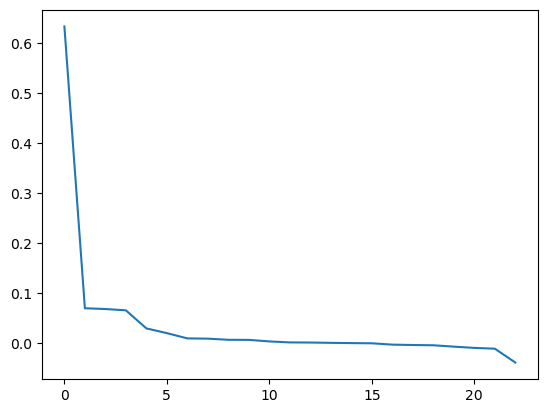

In [80]:
# Q,R = np.linalg.qr(norm_win_spectra[0].transpose())
# qr_approx = np.sort(np.diagonal(R@R.transpose()))[::-1]/np.sum(np.absolute(np.diagonal(R@R.transpose())))
qr_approx = np.sort((R@R.transpose())[0])[::-1]/np.sum(np.absolute((R@R.transpose())[0]))
plt.plot(qr_approx)

In [8]:
coherence, frequencies = welch_coherence(data_noise[start_ch:nchannels+start_ch:int(nchannels/200)], 5, 2.5, sample_interval=0.001)

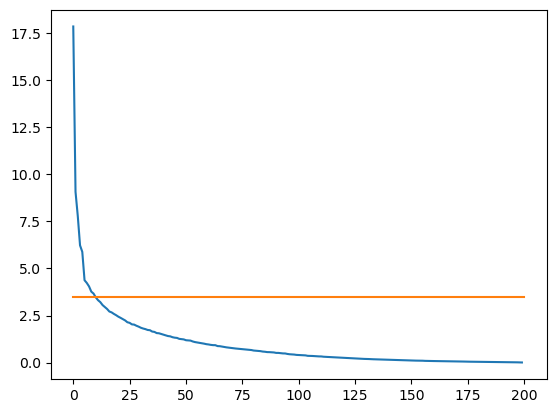

In [9]:
eigenvals, eigenvecs = np.linalg.eig(coherence[50])
# plt.imshow(coherence[0])
# plt.colorbar()
plt.plot(np.sort(eigenvals)[::-1])

perc95 = np.percentile(eigenvals,95)

plt.plot([0,200], [perc95,perc95])

eigenvals = np.sort(eigenvals)[::-1]
# np.where(eigenvals > np.percentile(eigenvals,95))

# eigenvals[0]/np.sum(eigenvals[1:])

(array([ 0.,  5., 10., 15., 20., 25., 30., 35., 40.]),
 [Text(0, 0.0, '0'),
  Text(0, 5.0, '5'),
  Text(0, 10.0, '10'),
  Text(0, 15.0, '15'),
  Text(0, 20.0, '20'),
  Text(0, 25.0, '25'),
  Text(0, 30.0, '30'),
  Text(0, 35.0, '35'),
  Text(0, 40.0, '40')])

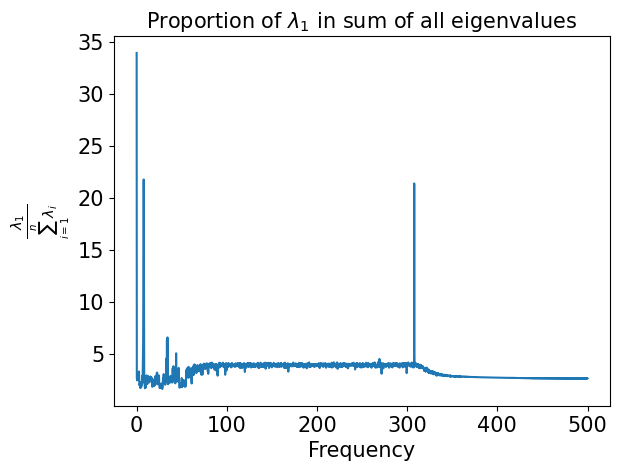

In [59]:
num_frames = coherence.shape[0]

eig_ratios = np.empty(num_frames)
for d in range(num_frames):
    eigenvals, _ = np.linalg.eig(coherence[d])
    eigenvals = np.sort(eigenvals)[::-1]
    eig_ratios[d] = eigenvals[0]/eigenvals[1] #np.sum(eigenvals)
plt.plot(frequencies, eig_ratios)
plt.ylabel(r"$\frac{\lambda_1}{\sum_{i=1}^{n}{\lambda_i}}$",fontsize=fsize)
plt.xlabel("Frequency",fontsize=fsize)
plt.title("Proportion of $\lambda_1$ in sum of all eigenvalues",fontsize=fsize)
plt.xticks(fontsize=fsize)
plt.yticks(fontsize=fsize)

### Plot data

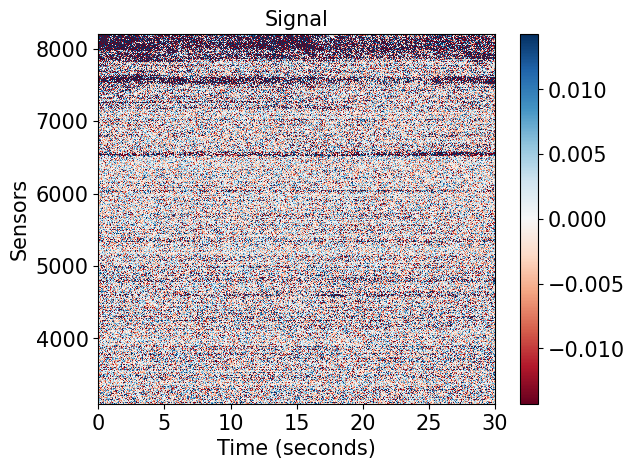

In [28]:
# pdata=np.append(data[:,24976:],data2[:,:10000],axis=1) 
pdata=data_noise
pdata = pdata[start_ch:nchannels+start_ch]

fig2 = plt.figure()
img2 = plt.imshow(pdata, cmap="RdBu", 
           vmin=-np.percentile(np.absolute(pdata),90), 
           vmax=np.percentile(np.absolute(pdata),90), aspect='auto', interpolation='none',
           extent=(0,len(pdata[0])/samples_per_sec, start_ch, start_ch + nchannels))
           #extent=(mdates.date2num(np.datetime64(props['GPSTimeStamp'])),mdates.date2num(np.datetime64(props['GPSTimeStamp'])+np.timedelta64(60,'s')), distances[0],distances[-1]))
plt.xlabel('Time (seconds)',fontsize=fsize)
plt.ylabel('Sensors',fontsize=fsize)
plt.title('Signal',fontsize=fsize)
plt.xticks(fontsize=fsize)
plt.yticks(fontsize=fsize)
cbar = plt.colorbar()
cbar.ax.tick_params(labelsize=fsize)

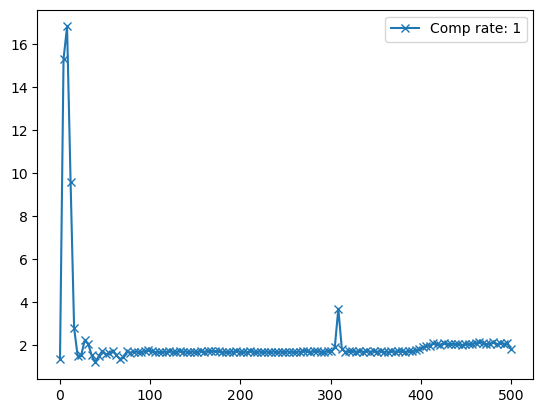

In [29]:
compression_factors = [1]
# compression_factors = [1,50,100]
# pdata=data_noise
# pdata = pdata[start_ch:nchannels+start_ch]
rows, columns = pdata.shape
nsensors = 200
evs = np.array([range(nsensors)])

f, Cxy = ss.coherence(pdata[10], pdata[15], fs=1000)
approxRank = int((rows * columns) / (compression_factors[0] * (rows + columns)))
# calculate randomized SVD and reconstruct
U, S, Vt = randomized_svd(pdata, n_components=approxRank)

for compression_factor in compression_factors:
    approxRank = int((rows * columns) / (compression_factor * (rows + columns)))
    recon = U[:,:approxRank] @ np.diag(S[:approxRank]) @ Vt[:approxRank,:]

    i = 0
    j = 0
    cube = np.empty([nsensors, nsensors, len(Cxy)])
    for a in np.linspace(0,len(recon)-1,nsensors):
        for b in np.linspace(0,len(recon)-1,nsensors):
            a=int(a)
            b=int(b)
            # f, C = ss.coherence(recon[a], recon[int(b)], fs=1000)
            # cube[i,j,:] = C
            if a <= b:
                f, C = ss.coherence(recon[a], recon[b], fs=1000)
                cube[i,j,:] = C
            else:
                cube[i,j,:] = cube[j,i,:] 
            j+=1
        i+=1
        j=0
    eigenvals, eigenvecs = np.linalg.eig(cube[:,:,2])
    eigenvals = np.sort(eigenvals)[::-1]
    # plt.plot(eigenvals, '-x', label="Comp rate: "+ str(compression_factor))
    # evs = np.append(evs, eigenvals[np.newaxis,:], axis=0)
    num_frames = len(C)
    eig_ratios = np.empty(num_frames)
    for d in range(num_frames):
        eigenvals, _ = np.linalg.eig(cube[:,:,d])
        eigenvals = np.sort(eigenvals)[::-1]
        eig_ratios[d] = eigenvals[0]/eigenvals[1]
    plt.plot(f, eig_ratios, "-x", label="Comp rate: "+ str(compression_factor))
plt.legend()

# Small event test

In [5]:
file = r"D:\CSM\Mines_Research\Test_data\Brady Hotspring\PoroTomo_iDAS16043_160314083848.h5"
data,_ = loadBradyHShdf5(file,normalize='no')

file = r"D:\CSM\Mines_Research\Test_data\Brady Hotspring\PoroTomo_iDAS16043_160314083918.h5"
data2,_= loadBradyHShdf5(file,normalize='no')

# signalToUse=np.append(data[:,24976:],data2[:,:10000],axis=1)
data = np.append(data,data,axis=1)


In [6]:
coherence2, frequencies = welch_coherence(data[start_ch:nchannels+start_ch:int(nchannels/200)], 5, 2.5, sample_interval=0.001)

In [75]:
norm_win_spectra2, frequencies = normalised_windowed_spectra(data[start_ch:nchannels+start_ch:int(nchannels/200)], 5, 2.5, sample_interval=0.001)

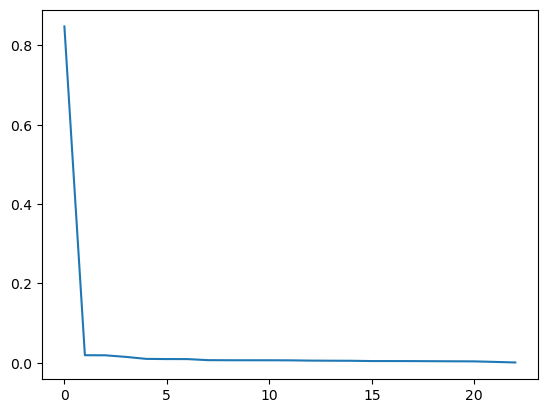

In [78]:
Q2,R2 = np.linalg.qr(norm_win_spectra2[40].transpose())
qr_approx = np.sort(np.diagonal(R@R.transpose()))[::-1]/np.sum(np.absolute(np.diagonal(R@R.transpose())))
# qr_approx = np.sort((R2@R2.transpose())[0])[::-1]/np.sum(np.absolute((R2@R2.transpose())[0]))
plt.plot(qr_approx)

c:\Users\issah\anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:1335: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


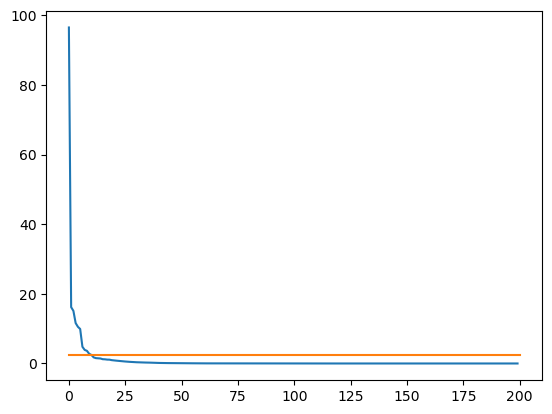

In [7]:
eigenvals, eigenvecs = np.linalg.eig(coherence2[50])
# plt.imshow(coherence[50])
# plt.colorbar()
plt.plot(np.sort(eigenvals)[::-1])

perc95 = np.percentile(eigenvals,95)

plt.plot([0,200], [perc95,perc95])

# eigenvals = np.sort(eigenvals)[::-1]


C:\Users\issah\AppData\Local\Temp\ipykernel_30404\2311572136.py:7: ComplexWarning: Casting complex values to real discards the imaginary part
  eig_ratios2[d] = eigenvals[0]/np.sum(eigenvals)


(array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]),
 [Text(0, 0.0, '0.0'),
  Text(0, 0.1, '0.1'),
  Text(0, 0.2, '0.2'),
  Text(0, 0.30000000000000004, '0.3'),
  Text(0, 0.4, '0.4'),
  Text(0, 0.5, '0.5'),
  Text(0, 0.6000000000000001, '0.6'),
  Text(0, 0.7000000000000001, '0.7'),
  Text(0, 0.8, '0.8'),
  Text(0, 0.9, '0.9')])

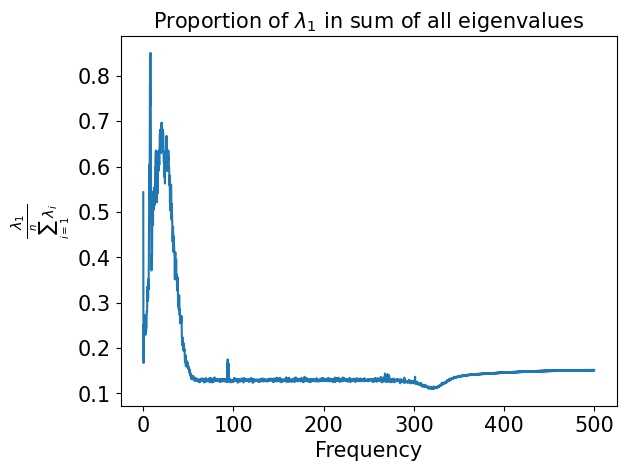

In [8]:
num_frames = coherence2.shape[0]

eig_ratios2 = np.empty(num_frames)
for d in range(num_frames):
    eigenvals, _ = np.linalg.eig(coherence2[d])
    eigenvals = np.sort(eigenvals)[::-1]
    eig_ratios2[d] = eigenvals[0]/np.sum(eigenvals)
plt.plot(frequencies, eig_ratios2)
plt.ylabel(r"$\frac{\lambda_1}{\sum_{i=1}^{n}{\lambda_i}}$",fontsize=fsize)
plt.xlabel("Frequency",fontsize=fsize)
plt.title("Proportion of $\lambda_1$ in sum of all eigenvalues",fontsize=fsize)
plt.xticks(fontsize=fsize)
plt.yticks(fontsize=fsize)

(array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]),
 [Text(0, 0.0, '0.0'),
  Text(0, 0.1, '0.1'),
  Text(0, 0.2, '0.2'),
  Text(0, 0.30000000000000004, '0.3'),
  Text(0, 0.4, '0.4'),
  Text(0, 0.5, '0.5'),
  Text(0, 0.6000000000000001, '0.6'),
  Text(0, 0.7000000000000001, '0.7'),
  Text(0, 0.8, '0.8'),
  Text(0, 0.9, '0.9')])

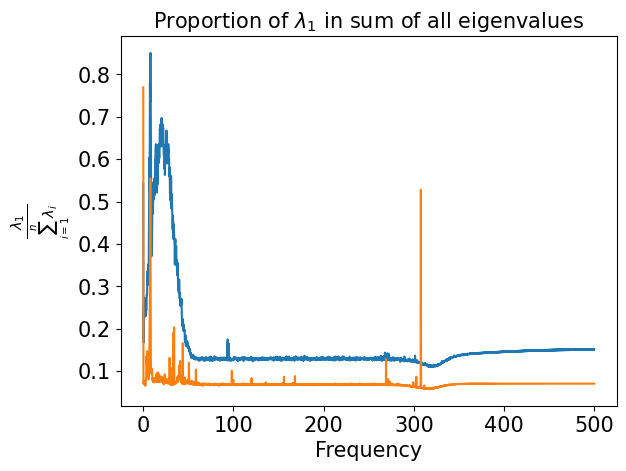

In [54]:
plt.plot(frequencies, eig_ratios2)
plt.plot(frequencies, eig_ratios)
plt.ylabel(r"$\frac{\lambda_1}{\sum_{i=1}^{n}{\lambda_i}}$",fontsize=fsize)
plt.xlabel("Frequency",fontsize=fsize)
plt.title("Proportion of $\lambda_1$ in sum of all eigenvalues",fontsize=fsize)
plt.xticks(fontsize=fsize)
plt.yticks(fontsize=fsize)


(array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8]),
 [Text(0, 0.0, '0.0'),
  Text(0, 0.1, '0.1'),
  Text(0, 0.2, '0.2'),
  Text(0, 0.30000000000000004, '0.3'),
  Text(0, 0.4, '0.4'),
  Text(0, 0.5, '0.5'),
  Text(0, 0.6000000000000001, '0.6'),
  Text(0, 0.7000000000000001, '0.7'),
  Text(0, 0.8, '0.8')])

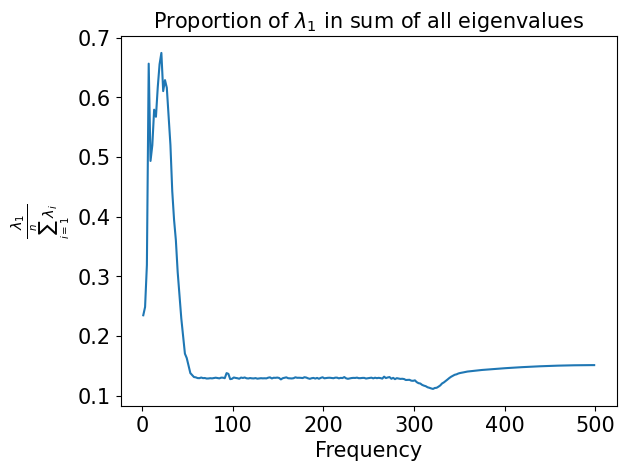

In [10]:

# avg_eigs = np.mean(eig_ratios[1:].reshape((250,10)), axis=1)
avg_eigs2 = np.mean(eig_ratios2[1:].reshape((250,10)), axis=1)
avg_freq = np.linspace(1,499,250)

# plt.plot(avg_freq, avg_eigs)
plt.plot(avg_freq, avg_eigs2)
plt.ylabel(r"$\frac{\lambda_1}{\sum_{i=1}^{n}{\lambda_i}}$",fontsize=fsize)
plt.xlabel("Frequency",fontsize=fsize)
plt.title("Proportion of $\lambda_1$ in sum of all eigenvalues",fontsize=fsize)
plt.xticks(fontsize=fsize)
plt.yticks(fontsize=fsize)

### Plot data

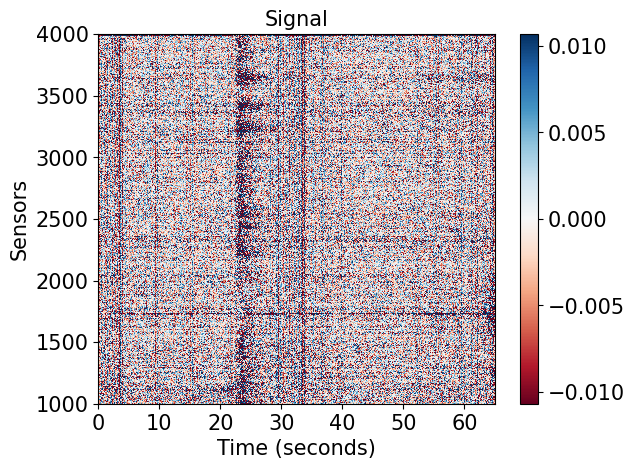

In [55]:
pdata=np.append(data[:,24976:],data2,axis=1) #data[:,10000:] # data[:,10000:25000]
pdata = pdata[start_ch:nchannels+start_ch]

fig2 = plt.figure()
img2 = plt.imshow(pdata, cmap="RdBu", 
           vmin=-np.percentile(np.absolute(pdata),90), 
           vmax=np.percentile(np.absolute(pdata),90), aspect='auto', interpolation='none',
           extent=(0,len(pdata[0])/samples_per_sec, start_ch, start_ch + nchannels))
           #extent=(mdates.date2num(np.datetime64(props['GPSTimeStamp'])),mdates.date2num(np.datetime64(props['GPSTimeStamp'])+np.timedelta64(60,'s')), distances[0],distances[-1]))
plt.xlabel('Time (seconds)',fontsize=fsize)
plt.ylabel('Sensors',fontsize=fsize)
plt.title('Signal',fontsize=fsize)
plt.xticks(fontsize=fsize)
plt.yticks(fontsize=fsize)
cbar = plt.colorbar()
cbar.ax.tick_params(labelsize=fsize)

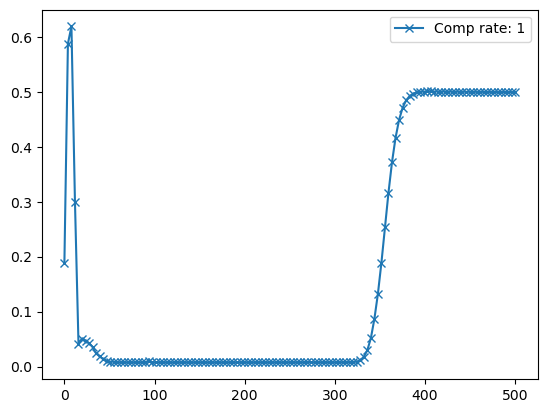

In [57]:
compression_factors = [1]
# compression_factors = [1,50,100]
# pdata=data_noise
# pdata = pdata[start_ch:nchannels+start_ch]
rows, columns = pdata.shape
nsensors = 200
evs = np.array([range(nsensors)])

f, Cxy = ss.coherence(pdata[10], pdata[15], fs=1000)
approxRank = int((rows * columns) / (compression_factors[0] * (rows + columns)))
# calculate randomized SVD and reconstruct
U, S, Vt = randomized_svd(pdata, n_components=approxRank)

for compression_factor in compression_factors:
    approxRank = int((rows * columns) / (compression_factor * (rows + columns)))
    recon = U[:,:approxRank] @ np.diag(S[:approxRank]) @ Vt[:approxRank,:]

    i = 0
    j = 0
    cube = np.empty([nsensors, nsensors, len(Cxy)])
    for a in np.linspace(0,len(recon)-1,nsensors):
        for b in np.linspace(0,len(recon)-1,nsensors):
            a=int(a)
            b=int(b)
            # f, C = ss.coherence(recon[a], recon[int(b)], fs=1000)
            # cube[i,j,:] = C
            if a <= b:
                f, C = ss.coherence(recon[a], recon[b], fs=1000)
                cube[i,j,:] = C
            else:
                cube[i,j,:] = cube[j,i,:] 
            j+=1
        i+=1
        j=0
    eigenvals, eigenvecs = np.linalg.eig(cube[:,:,2])
    eigenvals = np.sort(eigenvals)[::-1]
    # plt.plot(eigenvals, '-x', label="Comp rate: "+ str(compression_factor))
    # evs = np.append(evs, eigenvals[np.newaxis,:], axis=0)
    num_frames = len(C)
    eig_ratios = np.empty(num_frames)
    for d in range(num_frames):
        eigenvals, _ = np.linalg.eig(cube[:,:,d])
        eigenvals = np.sort(eigenvals)[::-1]
        eig_ratios[d] = eigenvals[0]/np.sum(eigenvals)
    plt.plot(f, eig_ratios, "-x", label="Comp rate: "+ str(compression_factor))
plt.legend()

# Big event test

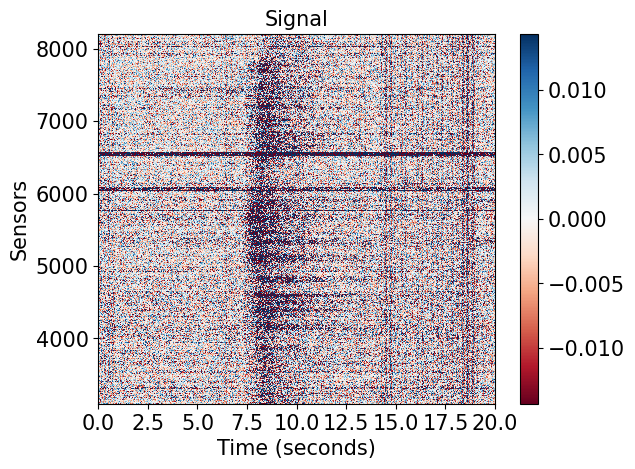

In [23]:
fsize=15
pdata=data[:,10000:] # signalToUse[1900:3900]

# start_ch = 3100
# nchannels = 5100

pdata = pdata[start_ch:nchannels+start_ch]
fig2 = plt.figure()
img2 = plt.imshow(pdata, cmap="RdBu", 
           vmin=-np.percentile(np.absolute(pdata),90), 
           vmax=np.percentile(np.absolute(pdata),90), aspect='auto', interpolation='none',
           extent=(0,len(pdata[0])/samples_per_sec, start_ch, start_ch + nchannels))
           #extent=(mdates.date2num(np.datetime64(props['GPSTimeStamp'])),mdates.date2num(np.datetime64(props['GPSTimeStamp'])+np.timedelta64(60,'s')), distances[0],distances[-1]))
plt.xlabel('Time (seconds)',fontsize=fsize)
plt.ylabel('Sensors',fontsize=fsize)
plt.title('Signal',fontsize=fsize)
plt.xticks(fontsize=fsize)
plt.yticks(fontsize=fsize)
cbar = plt.colorbar()
cbar.ax.tick_params(labelsize=fsize)

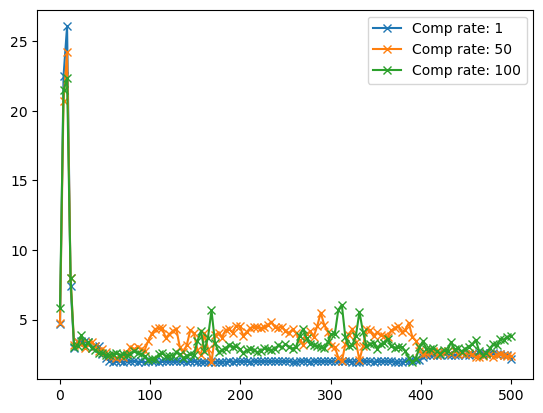

In [24]:
compression_factors = [1,50,100]
# pdata=data_noise
# pdata = pdata[start_ch:nchannels+start_ch]
rows, columns = pdata.shape
nsensors = 200
evs = np.array([range(nsensors)])

approxRank = int((rows * columns) / (compression_factors[0] * (rows + columns)))
# calculate randomized SVD and reconstruct
U, S, Vt = randomized_svd(pdata, n_components=approxRank)

for compression_factor in compression_factors:
    approxRank = int((rows * columns) / (compression_factor * (rows + columns)))
    recon = U[:,:approxRank] @ np.diag(S[:approxRank]) @ Vt[:approxRank,:]

    i = 0
    j = 0
    cube = np.empty([nsensors, nsensors, len(Cxy)])
    for a in np.linspace(0,len(recon)-1,nsensors):
        for b in np.linspace(0,len(recon)-1,nsensors):
            a=int(a)
            b=int(b)
            # f, C = ss.coherence(recon[a], recon[int(b)], fs=1000)
            # cube[i,j,:] = C
            if a <= b:
                f, C = ss.coherence(recon[a], recon[b], fs=1000)
                cube[i,j,:] = C
            else:
                cube[i,j,:] = cube[j,i,:] 
            j+=1
        i+=1
        j=0
    eigenvals, eigenvecs = np.linalg.eig(cube[:,:,2])
    eigenvals = np.sort(eigenvals)[::-1]
    # plt.plot(eigenvals, '-x', label="Comp rate: "+ str(compression_factor))
    # evs = np.append(evs, eigenvals[np.newaxis,:], axis=0)
    num_frames = len(C)
    eig_ratios = np.empty(num_frames)
    for d in range(num_frames):
        eigenvals, _ = np.linalg.eig(cube[:,:,d])
        eigenvals = np.sort(eigenvals)[::-1]
        eig_ratios[d] = eigenvals[0]/np.sum(eigenvals)
    plt.plot(f, eig_ratios, "-x", label="Comp rate: "+ str(compression_factor))
plt.legend()